In [2]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import astropy.constants as const
import matplotlib

from plotting import label_axes as axes_labels

References:
- Padovani, M., Bracco, A., Jelić, V., Galli, D., & Bellomi, E. (2021). Spectral index of synchrotron emission: insights from the diffuse and magnetised interstellar medium. In Astronomy &amp; Astrophysics (Vol. 651, p. A116). EDP Sciences. https://doi.org/10.1051/0004-6361/202140799
- Aharonian, F. A., Kelner, S. R., & Prosekin, A. Yu. (2010). Angular, spectral, and time distributions of highest energy protons and associated secondary gamma rays and neutrinos propagating through extragalactic magnetic and radiation fields. In Physical Review D (Vol. 82, Issue 4). American Physical Society (APS). https://doi.org/10.1103/physrevd.82.043002
- https://www.gb.nrao.edu/20m/map20m_advice.html
- Ginzburg, V. L., & Syrovatskii, S. I. (1965). Cosmic Magnetobremsstrahlung (Synchrotron Radiation). In Annual Review of Astronomy and Astrophysics (Vol. 3, Issue 1, pp. 297–350). Annual Reviews. https://doi.org/10.1146/annurev.aa.03.090165.001501

In [3]:
NU_MIN = 480e6 * u.Hz
NU_MAX = 8e9 * u.Hz
Hz = 1 * u.Hz
nu_grid = (
    np.logspace(np.log10(NU_MIN / Hz).value, np.log10(NU_MAX / Hz).value, 100, base=10)
    * u.Hz
)

T_MAX = 250 * u.K
T_SPECTRAL_INDEX = 2.8
T_vals = T_MAX * np.pow(nu_grid / NU_MIN, -T_SPECTRAL_INDEX)

B_Gauss = 3e-6 * u.G
# manual G -> cgs conversion because astropy is weird...
B = B_Gauss.value * u.cm ** (-1 / 2) * u.g ** (1 / 2) * u.s ** (-1)
nu_L = ((const.e.gauss * B) / (const.m_e * const.c)).to(u.Hz)

# Problem setup

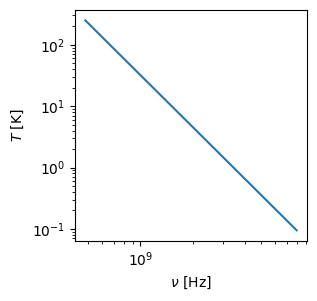

In [4]:
fig, ax = plt.subplots(figsize=(3, 3))
ax: plt.Axes

ax.plot(nu_grid, T_vals)

axes_labels(ax, "\\nu", "T")
ax.set_yscale("log")
ax.set_xscale("log")

plt.show()

Is $h \nu \ll kT$ approximation applicable within our frequency range?

In [5]:
print(f"kT   > {(const.k_B * T_MAX * np.pow(NU_MAX / NU_MIN, -T_SPECTRAL_INDEX)).to(u.eV):.2e}")
print(f"h nu < {(const.h * NU_MAX).to(u.eV):.2e}")

kT   > 8.17e-06 eV
h nu < 3.31e-05 eV


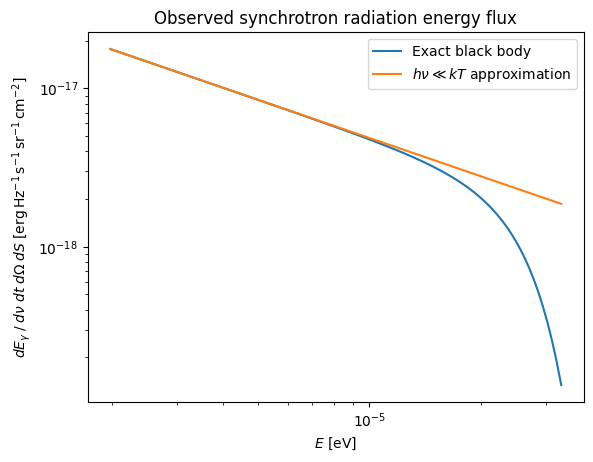

In [6]:
from astropy.modeling.models import BlackBody

fig, ax = plt.subplots()
ax: plt.Axes

dNdE_units = u.photon / (u.m**2 * u.s * u.eV * u.sr)
spectral_kw = dict(equivalencies=u.spectral())

I_exact = BlackBody(temperature=T_vals)(nu_grid)
I_approx = T_vals.to(
    I_exact.unit, equivalencies=u.brightness_temperature(frequency=nu_grid)
)
E_photon_grid = nu_grid.to(u.eV, **spectral_kw)
ax.plot(E_photon_grid, I_exact, label="Exact black body")
ax.plot(E_photon_grid, I_approx, label="$ h\\nu \\ll kT$ approximation")

axes_labels(ax, "E", "dE_{\\gamma} \\; / \\; d \\nu \\; dt \\; d\\Omega \\; dS")

ax.set_title("Observed synchrotron radiation energy flux")
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend()
plt.show()

No! But it is true for $\approx 80\%$ of the range, so we can probably assume it in the simplest approximation

# Synchrotron spectrum

Let's characterize synchrotron emission from a single electron with energy $E_e$, randomly oriented w.r.t. $\vec{B}$.
The equation for spectral (per unit frequency $\nu$) power distribution as function of *photon energy*, is

$$
J_\nu^{(1)}(E_\gamma, E_e) \equiv \frac{dE_{\text{syn}}}{d\nu \; dt} = \frac{\sqrt{3} e^3 B}{m_e c^2} G\left( \frac{E_\gamma}{E_C} \right) \\
E_C = \frac{3 e \hbar B}{2 m_e c} \left( \frac{E_e}{m_e c^2} \right)^2
$$

$E_C$ is characteristic energy, approximately around which the spectrum is peaked.

Here, $G$ is the "shape" function with $O(1)$ values. It has a closed form in terms of special functions,
in practice the approximation is used (see below).

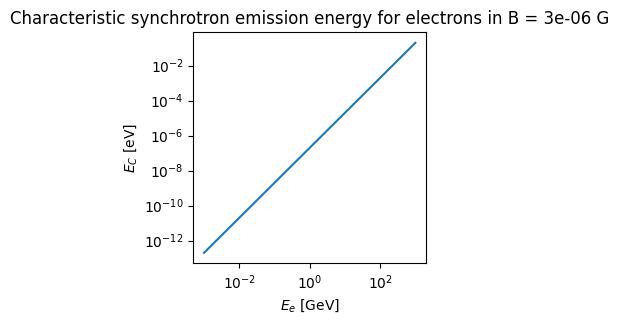

In [7]:
characteristic_energy_scale = (
    3 * const.e.gauss * const.h * B / (4 * np.pi * const.m_e**3 * const.c**5)
).to(1 / u.eV)


def characteristic_energy(E_e: u.Quantity) -> u.Quantity:
    return (characteristic_energy_scale * E_e**2).to(u.eV)


fig, ax = plt.subplots(figsize=(3, 3))
E_e = np.logspace(6, 12, 500, base=10) * u.eV
ax.plot(E_e.to(1e9 * u.eV), characteristic_energy(E_e))
ax.set_xlabel("$ E_e $ [GeV]")
ax.set_xscale("log")
ax.set_ylabel("$ E_{C} $ [eV]")
ax.set_yscale("log")
ax.set_title(f"Characteristic synchrotron emission energy for electrons in B = {B_Gauss}")
plt.show()

Spectrum shape

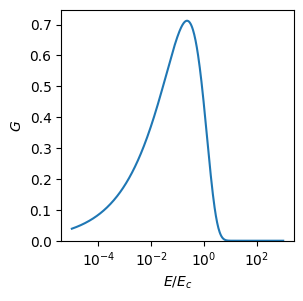

In [8]:
def G(x: np.ndarray) -> np.ndarray:
    """
    Eq. D7 from 10.1103/PhysRevD.82.043002 for approximation of angle-averaged synchrotron spectrum shape G(x)
    """
    x_13 = np.pow(x, 1 / 3)
    x_23 = np.pow(x, 2 / 3)
    x_43 = np.pow(x, 4 / 3)
    return (
        1.808
        * x_13
        / np.sqrt(1 + 3.4 * x_23)
        * ((1 + 2.21 * x_23 + 0.347 * x_43) / (1 + 1.353 * x_23 + 0.217 * x_43))
        * np.exp(-x)
    )


fig, ax = plt.subplots(figsize=(3, 3))
E_gamma = np.logspace(-5, 3, 500, base=10)
ax.plot(E_gamma, G(E_gamma))
ax.set_xlabel("$ E / E_{c} $")
ax.set_ylabel("$ G $")
ax.set_xscale("log")
ax.set_ylim(0)
plt.show()


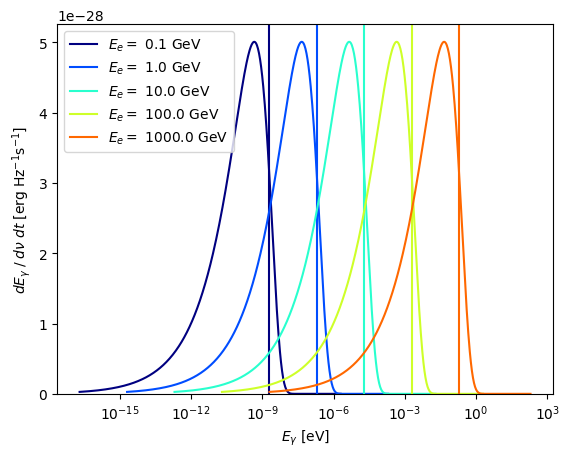

In [9]:
synchro_diff_flux_norm = np.sqrt(3) * (const.e.gauss**3) * B / (const.m_e * (const.c**2))


def synchro_diff_flux(E_gamma: u.Quantity, E_e: u.Quantity) -> np.ndarray:
    return (synchro_diff_flux_norm * G((E_gamma / characteristic_energy(E_e)).decompose())).to(
        u.erg / (u.Hz * u.s)
    )


fig, ax = plt.subplots()
cmap = matplotlib.colormaps.get("jet")
E_e_values = np.array([0.1, 1, 10, 100, 1000]) * u.GeV
for i, E_e in enumerate(E_e_values):
    E_c = characteristic_energy(E_e)
    E_gamma = (
        np.logspace(np.log10(E_c.value) - 8, np.log10(E_c.value) + 3, 500, base=10)
        * E_c.unit
    )
    color = cmap(i / len(E_e_values))
    ax.plot(
        E_gamma,
        synchro_diff_flux(E_gamma, E_e),
        label=f"$ E_e = $ {E_e:.1f}",
        color=color,
    )
    ax.axvline(E_c, color=color)

# ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim(bottom=0)

axes_labels(ax, "E_{\\gamma}", " _ ")
ax.set_ylabel(
    "$ dE_{\\gamma} \\; / \\; d \\nu \\; dt $ [$ \\mathrm{erg} \\; \\mathrm{Hz}^{-1} \\mathrm{s}^{-1} $]"
)
ax.legend()
plt.show()

# Synchrotron emission from electron population

Let's denote the electron spectrum $\Phi_e(E_e)$, treating it as the "number spectrum"
$\frac{dN_e}{dE_e}$ but normalized to a single particle ($\int \Phi_E(E_e) dE_e = 1$). The result
will be an emission from a single electron smeared according to the spectral shape, so
multiplying the result by population size $N_e$ will yield the population's emission.
Multiplying by density $n_e$ instead, we obtain the synchrotron emission per unit volume

Given the spectrum, the synchrotron emission is obtained by integration

$$
J_\nu(E_\gamma) = \int dE_e \Phi_e(E_e) J_\nu^{(1)}(E_\gamma, E_e)
$$

Single-electron emission can be written as a function of $E_\gamma / E_e^2$
$$
J_\nu^{(1)}(E_\gamma, E_e) =
    \frac{\sqrt{3} e^3 B}{m_e c^2}
    G\left( \frac{2 m_e^3 c^5 }{3 e \hbar B}  \frac{E_\gamma}{E_e^2} \right) 
    \equiv f \left(\frac{E_\gamma}{E_e^2} \right)
$$

The integral can be rewritten as a convolution in log space. To do that, we introduce $t_\gamma \equiv \ln (E_\gamma / \mathrm{eV})$,
$t_e \equiv \ln (E_e / \mathrm{eV})^2 = 2 \ln (E_e / \mathrm{eV})$. Integration now happens over $t_e$ with the differential $dE_e = \frac{e^{t_e/2} \mathrm{eV}}{2} dt_e$.

We introduce "log-space" functions, with single-electron emission spectrum playing the role of "impulse response"
and electron spectrum (plus coordinate change Jacobian) - of "source" signal. Then we immediately obtain the
desired spectrum as their convolution

$$
\tilde f(t_\gamma - t_e) \equiv f(e^{t_\gamma - t_e}) = f \left(\frac{E_\gamma(t_\gamma)}{E_e(t_e)^2} \right) \\
\tilde g(t_e) \equiv \frac{e^{t_e/2}}{2} \Phi_e(e^{t_e / 2}) \\
J_\nu(E_\gamma) = J_\nu(t_\gamma(E_\gamma)) = \int dt_e \tilde g(t_e) \tilde f(t_\gamma(E_\gamma) - t_e)
$$



In [10]:
t_step = 0.1

### Log-space version of a single-electron emission

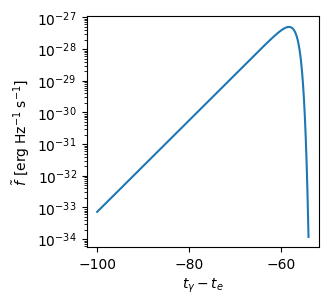

In [11]:
delta_t_min = -100
delta_t_max = -54
delta_t_grid = np.arange(delta_t_min, delta_t_max, step=t_step)

E_gamma_E_e_2_ratio = np.exp(delta_t_grid) * (1 / u.eV)
f_wave_vals = (
    synchro_diff_flux_norm * G(E_gamma_E_e_2_ratio / characteristic_energy_scale)
).to(u.erg / (u.Hz * u.s))


fig, ax = plt.subplots(figsize=(3, 3))

ax.plot(delta_t_grid, f_wave_vals)
ax.set_xlabel("$ t_\\gamma - t_e $")
ax.set_ylabel(
    "$ \\tilde f $ [$ \\mathrm{erg} \\; \\mathrm{Hz}^{-1} \\; \\mathrm{s}^{-1} $]"
)
ax.set_yscale("log")
plt.show()

### Electron population

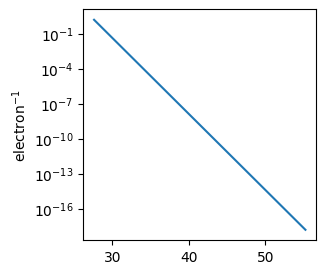

In [12]:
E_e_min = 1 * u.MeV
E_e_max = 1 * u.TeV
electron_spectrum_index = 4
spectrum_norm = 1 / (
    (1 / (electron_spectrum_index - 1))
    * (
        E_e_min
        - (E_e_max ** (1 - electron_spectrum_index))
        / (E_e_min**-electron_spectrum_index)
    )
    * u.electron
)


def electron_spectrum(E_e: u.Quantity) -> u.Quantity:
    return spectrum_norm * np.pow((E_e / E_e_min).decompose(), -electron_spectrum_index)


t_e_min = 2 * np.log(E_e_min.to(u.eV).value)
t_e_max = 2 * np.log(E_e_max.to(u.eV).value)
t_e_grid = np.arange(t_e_min, t_e_max, step=t_step)

E_e_grid = np.exp(t_e_grid / 2) * u.eV

g_wave_vals = (0.5 * E_e_grid * electron_spectrum(E_e_grid)).decompose()

fig, ax = plt.subplots(figsize=(3, 3))
ax.plot(t_e_grid, g_wave_vals)
ax.set_yscale("log")
plt.show()

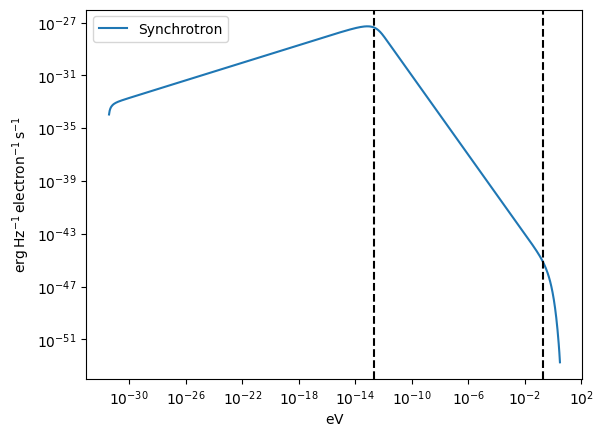

In [13]:
t_gamma_grid_length = t_e_grid.size + delta_t_grid.size - 1  # full convolution adds "tails"
t_gamma_grid = np.arange(t_e_min + delta_t_min, t_e_max + delta_t_max, step=t_step)
if t_gamma_grid.size != t_gamma_grid_length:
    t_gamma_grid = np.arange(t_e_min + delta_t_min, t_e_max + delta_t_max - t_step, step=t_step)
E_gamma_grid = np.exp(t_gamma_grid) * u.eV

# NOTE:                                   numerical convolution assumes INTEGRAL values,
#                                         VVVVV so we have to multiply by dE = step size
spectrum_vals = np.convolve(g_wave_vals * t_step, f_wave_vals, mode="full").to(
    u.erg / (u.electron * u.Hz * u.s)
)

E_break_1 = characteristic_energy_scale * E_e_min**2
E_break_2 = characteristic_energy_scale * E_e_max**2

fig, ax = plt.subplots()
ax.plot(E_gamma_grid, spectrum_vals, label="Synchrotron")
ax.axvline(E_break_1, color="k", linestyle="--")
ax.axvline(E_break_2, color="k", linestyle="--")
ax.legend()
ax.set_yscale("log")
ax.set_xscale("log")

## Electron spectrum reconstruction from the synchrotron emission

In principle, we just need to invert the process performed above: perform deconvolution in log space and extract electron spectrum.

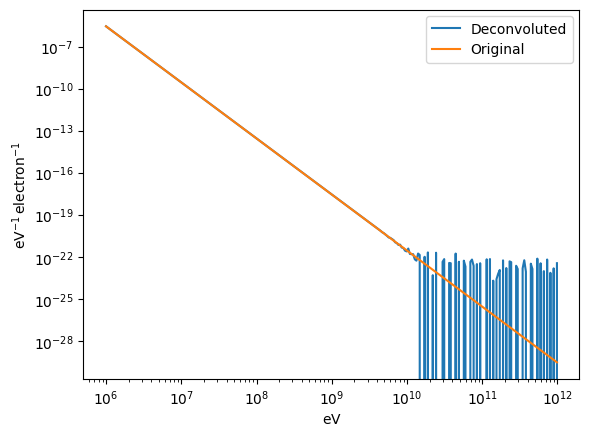

In [14]:
from scipy import signal

g_wave_dc, dc_error = signal.deconvolve(
    spectrum_vals.to(u.erg / (u.Hz * u.s * u.electron)).value,
    f_wave_vals.to(u.erg / (u.Hz * u.s)),
)
g_wave_dc /= t_step
dc_error /= t_step
g_wave_dc = g_wave_dc * g_wave_vals.unit
dc_error = dc_error * g_wave_vals.unit

fig, ax = plt.subplots()

ax.plot(E_e_grid, g_wave_dc / (E_e_grid * 0.5), label="Deconvoluted")
ax.plot(E_e_grid, g_wave_vals / (E_e_grid * 0.5), label="Original")
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend()

plt.show()